<a href="https://colab.research.google.com/github/rimosoma/ML_for_healt/blob/main/lab4healt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.close('all')

ALL_INFO_FLAG = False
plotCDF=True # change to True if you want the plots


In [2]:
#PART 1: LOOKING AND CORRECTING THE DATASET

#%%
# define the feature names:
feat_names=['age','bp','sg','al','su','rbc','pc',
'pcc','ba','bgr','bu','sc','sod','pot','hemo',
'pcv','wbcc','rbcc','htn','dm','cad','appet','pe',
'ane','classk']
feat_cat=np.array(['num','num','cat','cat','cat','cat','cat','cat','cat',
         'num','num','num','num','num','num','num','num','num',
         'cat','cat','cat','cat','cat','cat','cat'])
# import the dataframe:
#xx=pd.read_csv("./Chronic_Kidney_Disease/chronic_kidney_disease.arff",sep=',',
#               skiprows=29,names=feat_names,
#               header=None,na_values=['?','\t?'],
#               warn_bad_lines=True)
xx=pd.read_csv("./chronic_kidney_disease_v2.arff",sep=',',
    skiprows=29,names=feat_names,
    header=None,na_values=['?','\t?'],)
Np,Nf=xx.shape
#%% change categorical data into numbers:
target_names = ['notckd','ckd']# for the final plots
mapping={
    'normal':0,
    'abnormal':1,
    'present':1,
    'notpresent':0,
    'yes':1,
    ' yes':1,
    'no':0,
    '\tno':0,
    '\tyes':1,
    'ckd':1,
    'notckd':0,
    'poor':1,
    'good':0,
    'ckd\t':1}
xx=xx.replace(mapping.keys(),mapping.values())


if ALL_INFO_FLAG:
    print("---------------------------------------")
    print("---------------------------------------")
    print('✅ALL_INFO_FLAG: ON; ⬇️⬇️⬇️⬇️⬇️⬇️⬇️')
    print('cardinality of each feature:')
    print(xx.nunique())# show the cardinality of each feature in the dataset; in particular classk should have only two possible values



    #%% find how many missing values are present in each row:
    miss_values = xx.isnull().sum(axis=1)
    for k in range(miss_values.max()+1):
        print(k,np.sum(miss_values==k))

    print(xx.info())

else:

    print("---------------------------------------")
    print("---------------------------------------")
    print('❗ALL_INFO_FLAG: OFF')

---------------------------------------
---------------------------------------
❗ALL_INFO_FLAG: OFF


/tmp/ipython-input-2185087142.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xx=xx.replace(mapping.keys(),mapping.values())


---------------------------------------
---------------------------------------
📊​📊​BASIC INFO ABOUT THE DATA:
Number of points in the original dataset:  400
reduced dataset: at least 19 values per row
number of points in the reduced dataset:  349
max number of missing values in the reduced dataset:  6
Number of points in the training dataset(full 25 values):  158
---------------------------------------
---------------------------------------
📐​📐​DIMENSIONS OF THE FILLED DATASETS:
Dimensions of x_filled_reg: (349, 25)
missing values in x_filled_reg: 0
---------------------------------------
---------------------------------------
✅PLOTCDF: ON; 


/tmp/ipython-input-2742848877.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Dimensions of x_filled_med: (400, 25)
missing values in x_filled_med: 0


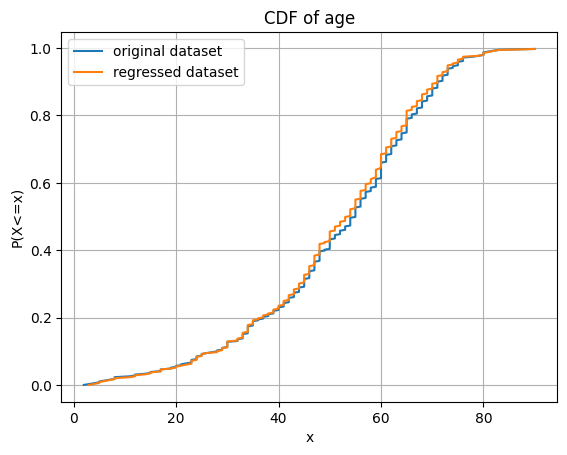

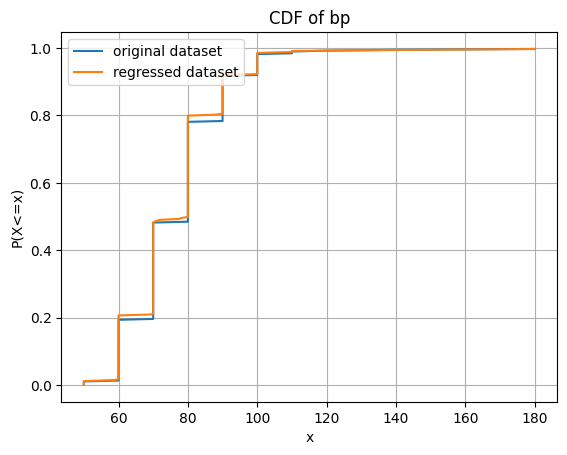

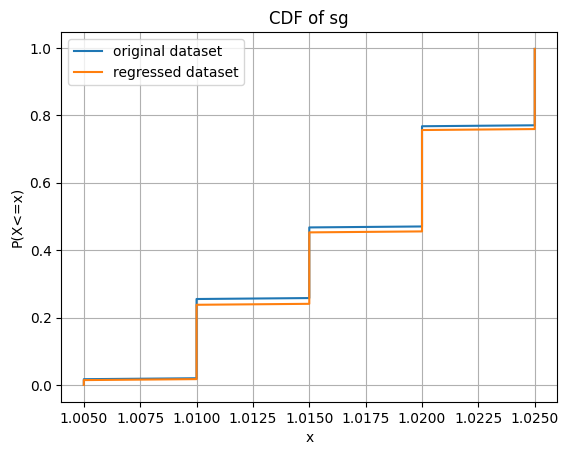

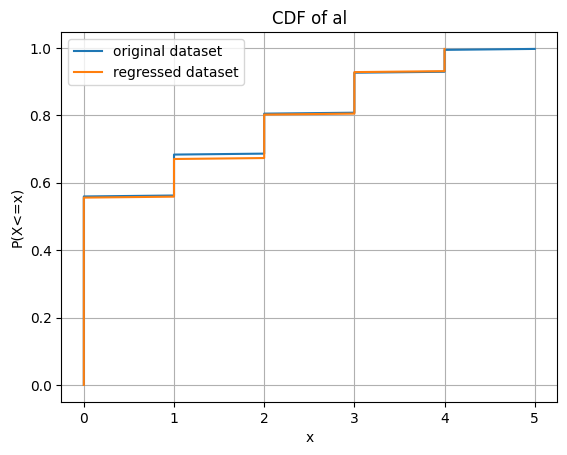

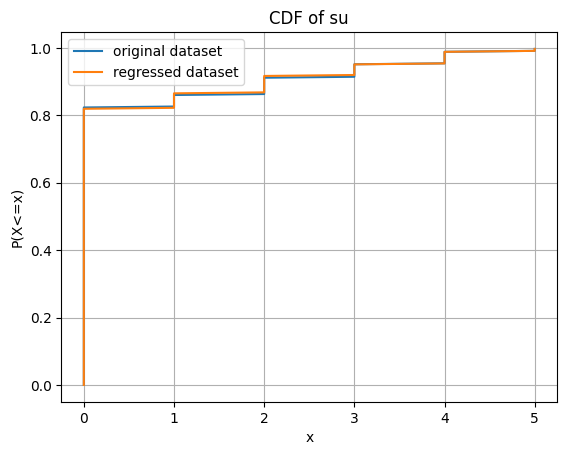

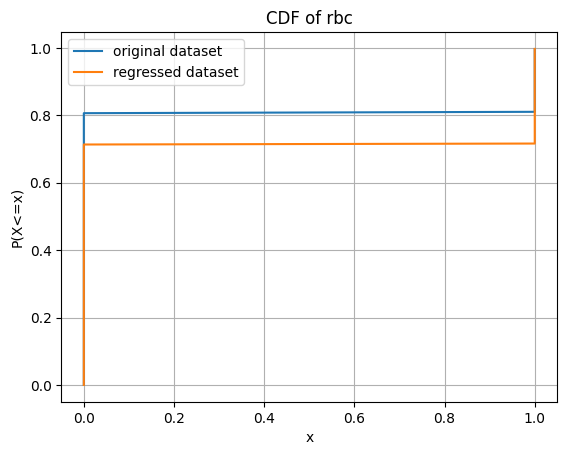

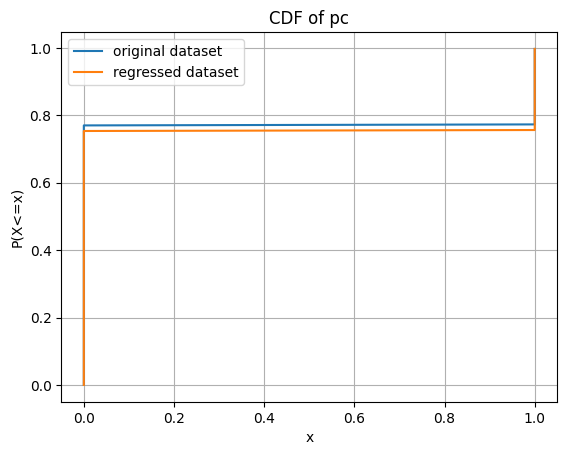

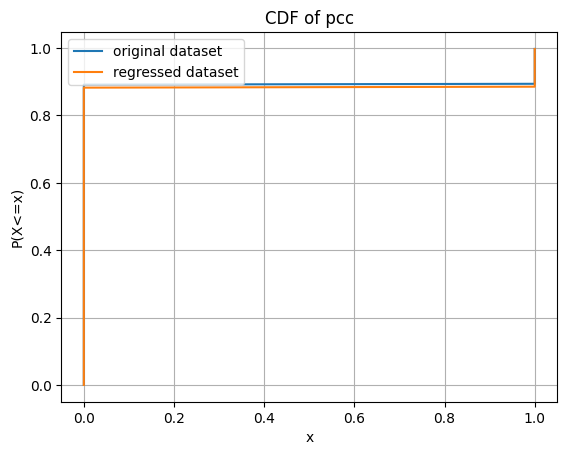

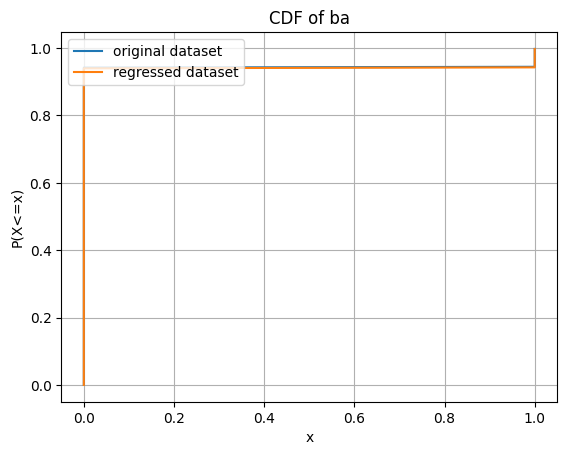

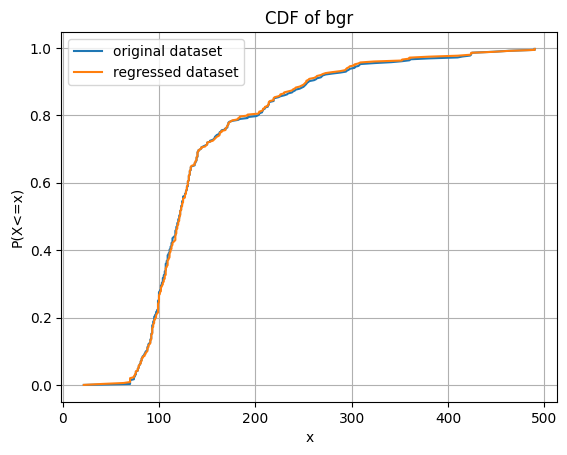

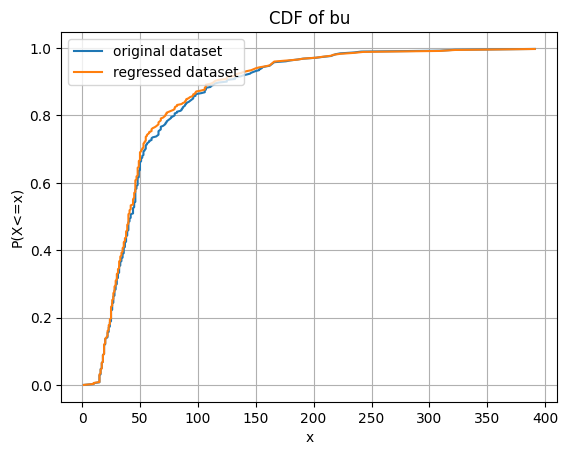

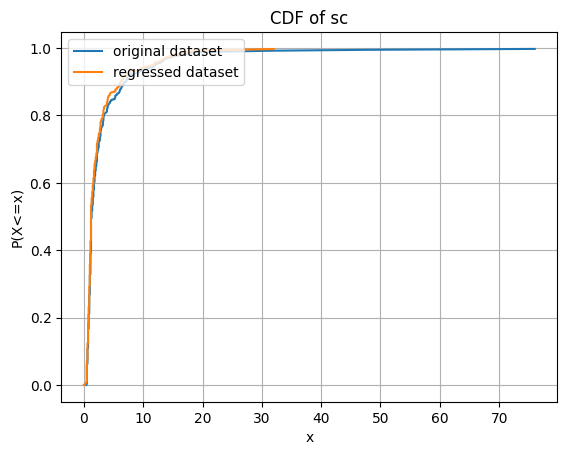

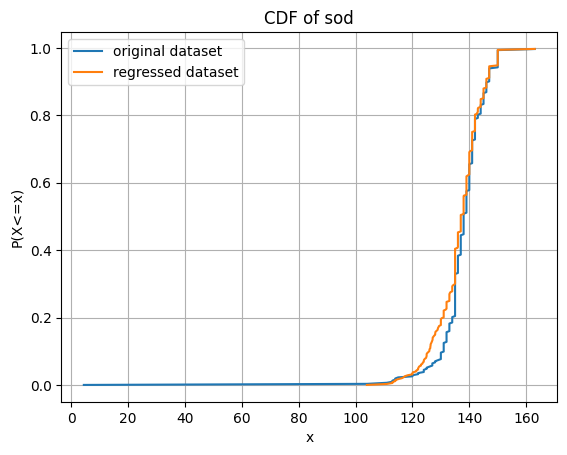

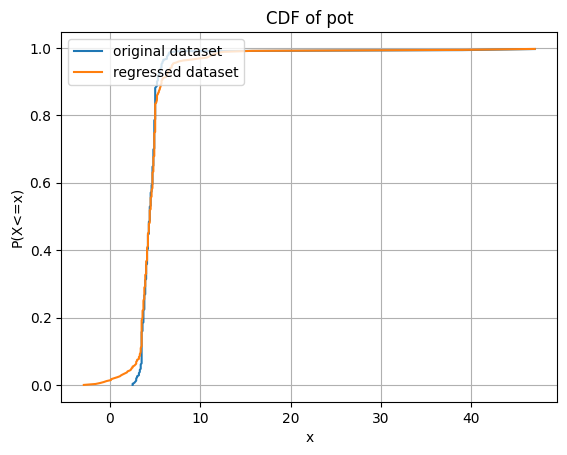

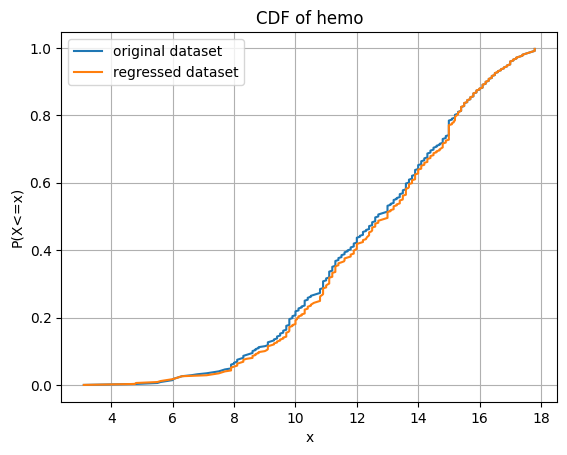

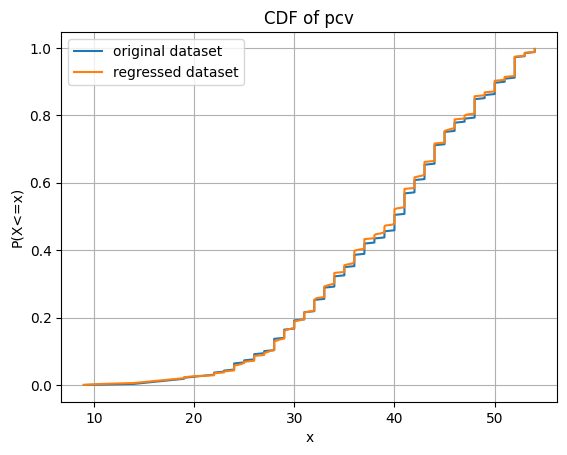

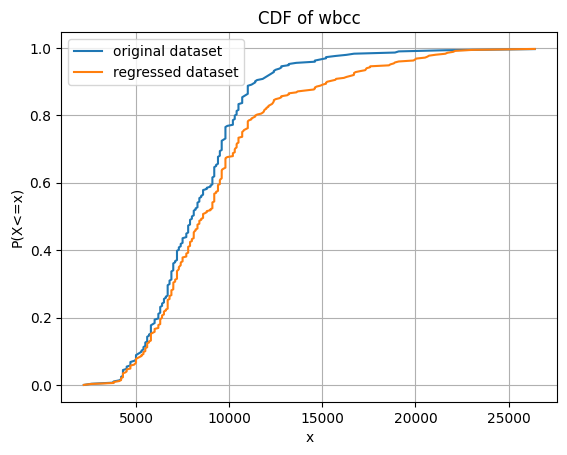

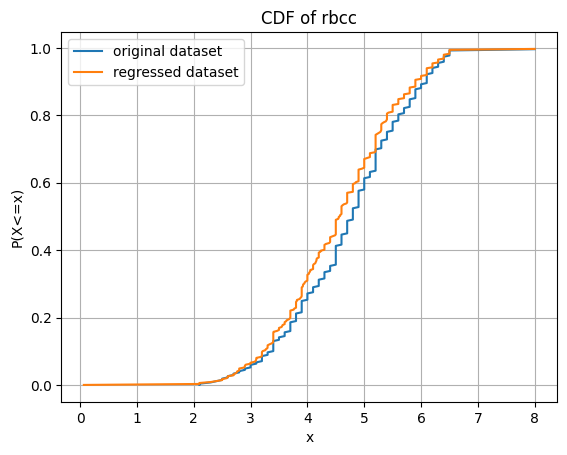

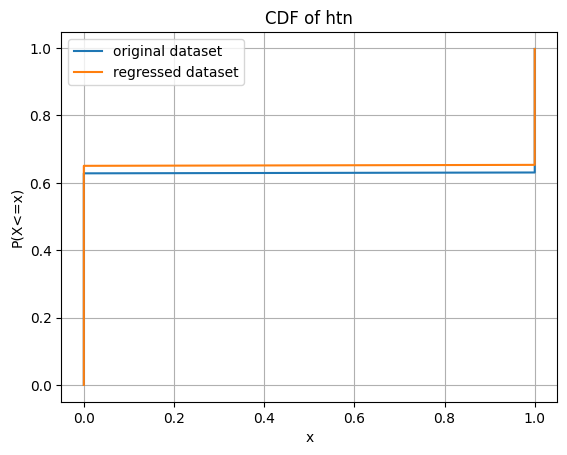

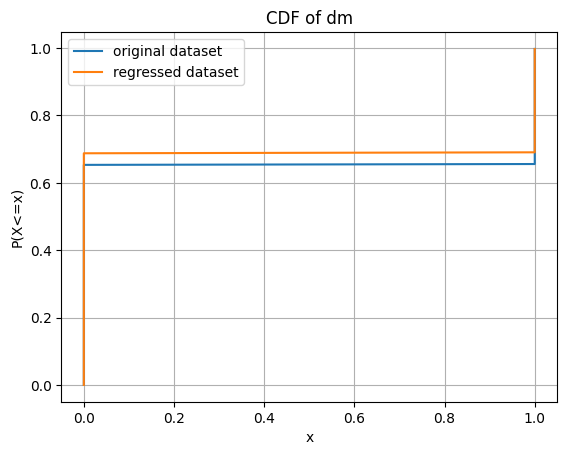

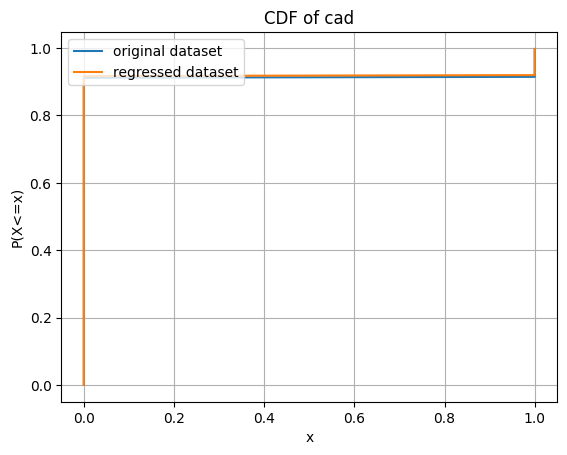

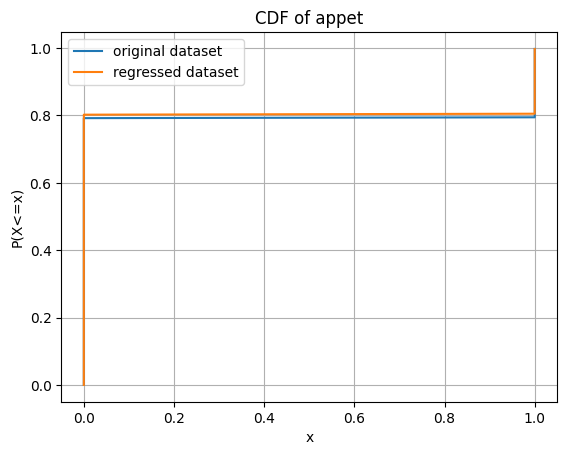

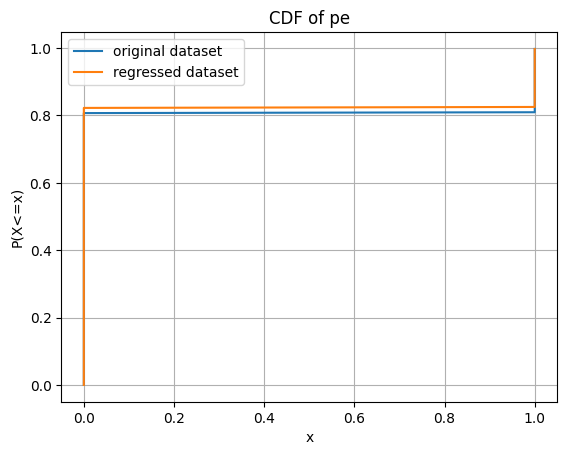

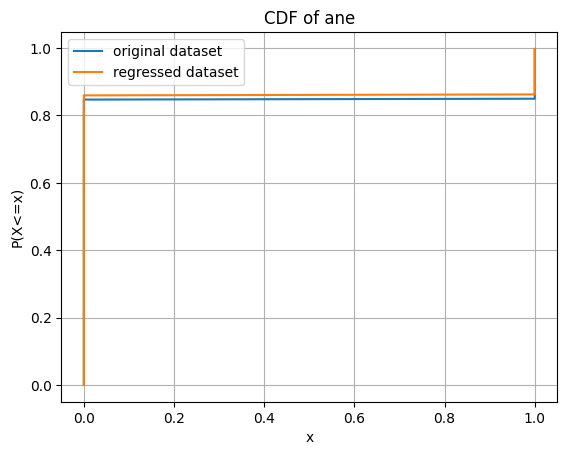

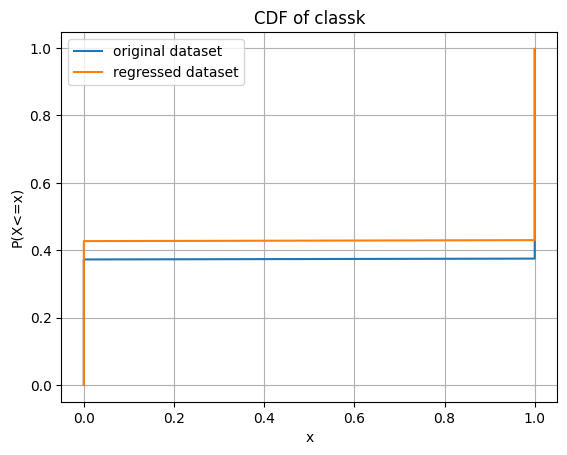

In [3]:
#PART 2: MISSING DATA RECOVERED BY REGRESSION OR MEDIAN/MODE

#%% manage the missing data through regression

x=xx.copy()
# drop rows with less than 19=Nf-6 recorded features, reconstruction won't be reliable:
x=x.dropna(thresh=19)
x.reset_index(drop=True, inplace=True)# necessary to have index without "jumps"
n=x.isnull().sum(axis=1)# check the number of missing values in each row
print("---------------------------------------")
print("---------------------------------------")
print('📊​📊​BASIC INFO ABOUT THE DATA:')
print('Number of points in the original dataset: ',xx.shape[0])
print('reduced dataset: at least 19 values per row')
print('number of points in the reduced dataset: ',x.shape[0])
print('max number of missing values in the reduced dataset: ',n.max())

# take the rows with exctly Nf=25 useful features; this is going to be the training dataset
# for regression
Xtrain=x.dropna(thresh=25)
Xtrain.reset_index(drop=True, inplace=True)# reset the index of the dataframe
print('Number of points in the training dataset(full 25 values): ',Xtrain.shape[0])


#REGRESSION ⬇️⬇️⬇️
#%% normalization
XtrainNp = Xtrain.values # Numpy 2D array
mm=XtrainNp.mean(axis=0)
ss=XtrainNp.std(axis=0)
XtrainNp_norm=(XtrainNp-mm)/ss
#% normalize the entire dataset using the coeffs found for the training dataset
X_normNp=(x.values-mm)/ss
Np,Nf=X_normNp.shape

#%% run linear regression using least squares on all the missing data
#for each rows, i use the other features as regressor to fnd the regressand(missing values)
for kk in range(Np):
    xrow = X_normNp[kk,:] # k-th row
    mask = np.isnan(xrow) # columns with nan in row k

    # Se non ci sono True nella maschera (0 valori mancanti), passa alla prossima riga
    if not np.any(mask):
        continue
    # -----------------------------
    else:
        Data_tr_norm=XtrainNp_norm[:,~mask]# remove the columns from the training dataset
        y_tr_norm=XtrainNp_norm[:,mask]# columns to be regressed
        w1=np.linalg.inv(np.dot(Data_tr_norm.T,Data_tr_norm))
        w=np.dot(np.dot(w1,Data_tr_norm.T),y_tr_norm)# weight vector
        ytest_norm=np.dot(xrow[~mask],w)
        xrow[mask]=ytest_norm
        X_normNp[kk]=xrow# substitute nan with regressed values
x_filled_reg=X_normNp*ss+mm # denormalize

#%% We see that the regressed values of categorical features take numerical values
#manage categorical features
# get the possible values for the categorical features
alphabets=[]   #alphabets is a list with the alphabets of all the categorical feature
for k in range(len(feat_cat)):  #feat_cat is a list of cat|num for each feature
    if feat_cat[k]=='cat':      #if the feature k is cathegorical:
        val=Xtrain[Xtrain.columns[k]].unique()  #its value must be one of the possible "quantized values" presen in the same column,
                                                #because before when i've converted categhorical into numerical, they
                                                #assumed quantized values. But the regressand ones no.
        alphabets.append(np.sort(val))          #i append this quantized values in the alphabets, for every feature
    else:
        alphabets.append('num')

   #So at the end I have a list of arrays(alphabets) in which i have in the respective positions
   #the arrays with the value that the cathegorical feature can assume.
   #es feat_cat=[cat,num,cat]       alphabets=[[0,1], num, [0,1,2,3]]

index=np.argwhere(feat_cat=='cat').flatten()   #index of the feature in feat_cat that are cathegorical
for k in index:
    val=alphabets[k].flatten()      #possible values fot the feature k
    c=x_filled_reg[:,k]             #takes the entire k-th column from the filled db(in which there are also the regressand values)
    val = val.reshape(1,-1) # force row vector
    c=c.reshape(-1,1) # force column vector
    d=(val-c)**2 # find the square distances
    ii=d.argmin(axis=1) # find the closest categorical value between each row value and the possible quantized
    cc=val[0,ii] # cc contains only the categorical values
    x_filled_reg[:,k]=cc
#
x_filled_reg= pd.DataFrame(x_filled_reg,columns=feat_names) # go back to Pandas dataframe
print("---------------------------------------")
print("---------------------------------------")
print('📐​📐​DIMENSIONS OF THE FILLED DATASETS:')
print(f"Dimensions of x_filled_reg: {x_filled_reg.shape}")
print(f"missing values in x_filled_reg: {x_filled_reg.isnull().sum().sum()}")



#%% check the distributions
L=x_filled_reg.shape[0]
if plotCDF:
    print("---------------------------------------")
    print("---------------------------------------")
    print('✅PLOTCDF: ON; ')
    for k in range(Nf):
        plt.figure()
        a=xx[xx.columns[k]].dropna()
        M=a.shape[0]
        plt.plot(np.sort(a),np.arange(M)/M,label='original dataset')
        plt.plot(np.sort(x_filled_reg[x_filled_reg.columns[k]]),np.arange(L)/L,label='regressed dataset')
        plt.title('CDF of '+xx.columns[k])
        plt.xlabel('x')
        plt.ylabel('P(X<=x)')
        plt.grid()
        plt.legend(loc='upper left')

# We are comparing two lines:
# 1. Original Dataset (Blue): The real data we had from the start (ignoring the missing rows).
# 2. Regressed Dataset (Orange): The dataset after we filled the missing "holes" using regression.
#
# WHY IS THIS IMPORTANT?
# We want to check if our method for filling the holes (Regression) was realistic.
# - If the lines OVERLAP: Great! The values we guessed follow the same rules/patterns as the real data.
# - If the lines are DIFFERENT: Danger. It means our filling method distorted the data
#   (e.g., we predicted too many high values or too many low values), changing the dataset's nature.
else:
    print('PLOTCDF: OFF')


#MEDIAN ⬇️⬇️⬇️
# %% --- TASK 3: Create x_filled_med (Median Imputation) ---

# 1. We calculate the median for each column using ONLY the clean training set (Xtrain).
# We use Xtrain to avoid data leakage (we don't store the data we need to predict).
medians = Xtrain.median()

# 2. Let's take the original dataset xx (which has 400 rows and numerically mapped values)
# but it still contains the NaNs
x_filled_med = xx.copy()

# 3. Fill the Nans with the medians
x_filled_med = x_filled_med.fillna(medians)

print(f"Dimensions of x_filled_med: {x_filled_med.shape}") # Deve essere (400, 25)
print(f"missing values in x_filled_med: {x_filled_med.isnull().sum().sum()}") # Deve essere 0







---------------------------------------
---------------------------------------
🌲​🌲​DECISION TREES TRAINED OVER THE TRAIN SET(ROWS WITHOUT MISSING):
📈C4.5(ENTROPY) OVER X :
Performance of the decision tree based on the training dataset only:
accuracy = 0.9169054441260746
[[150   0]
 [ 29 170]]
​📉CART(GINI) OVER x :
Performance of the decision tree based on the training dataset only:
accuracy = 0.8882521489971347
[[150   0]
 [ 39 160]]
---------------------------------------
---------------------------------------
🪾🪾RANDOM FOREST TRAINED USING THE FULL SETS x_filled_reg and x_filled_med:

--- Random Forest (100 trees) Results ---
Accuracy su x_filled_reg (Regression): 0.9656
Confusion Matrix x_filled_reg:
[[150   0]
 [ 12 187]]
 
Accuracy su x_filled_med (Median): 0.8750
Confusion Matrix x_filled_med:
[[150   0]
 [ 50 200]]
--------------------------------------- 

--- Random Forest (1000 trees) Results ---
Accuracy su x_filled_reg (Regression): 0.9685
Confusion Matrix x_filled_reg:
[[1

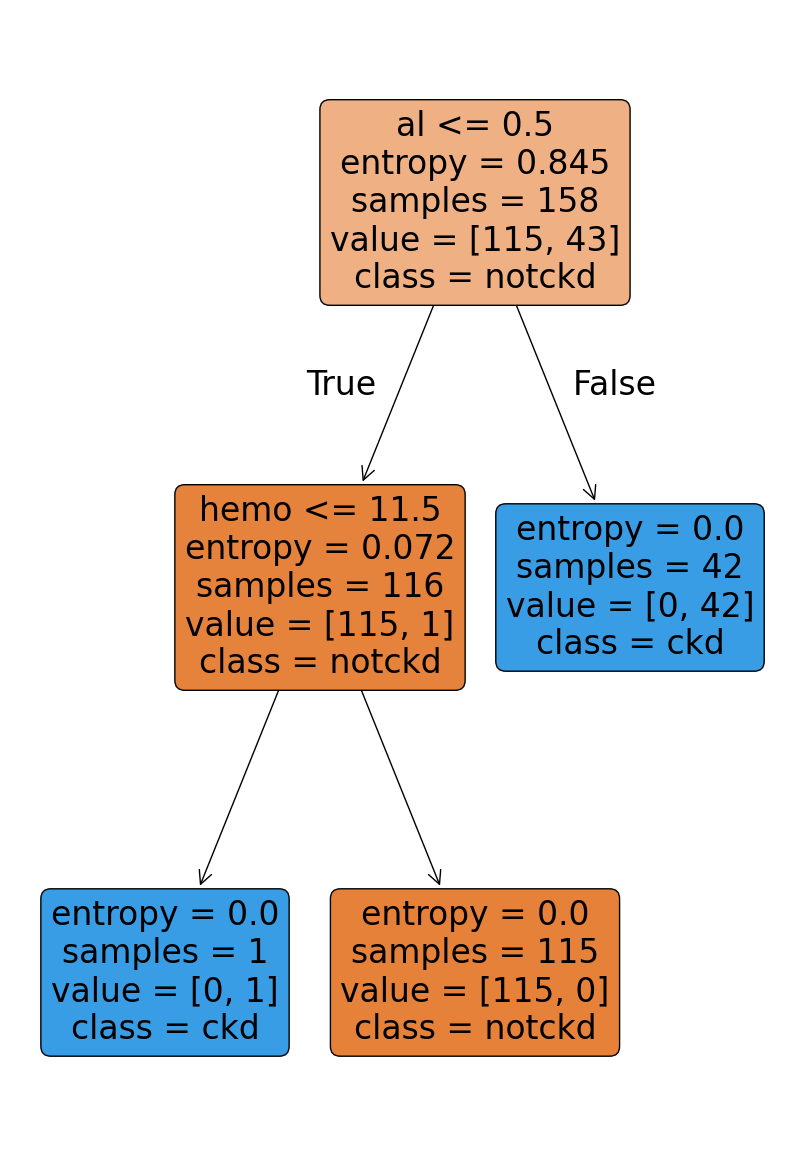

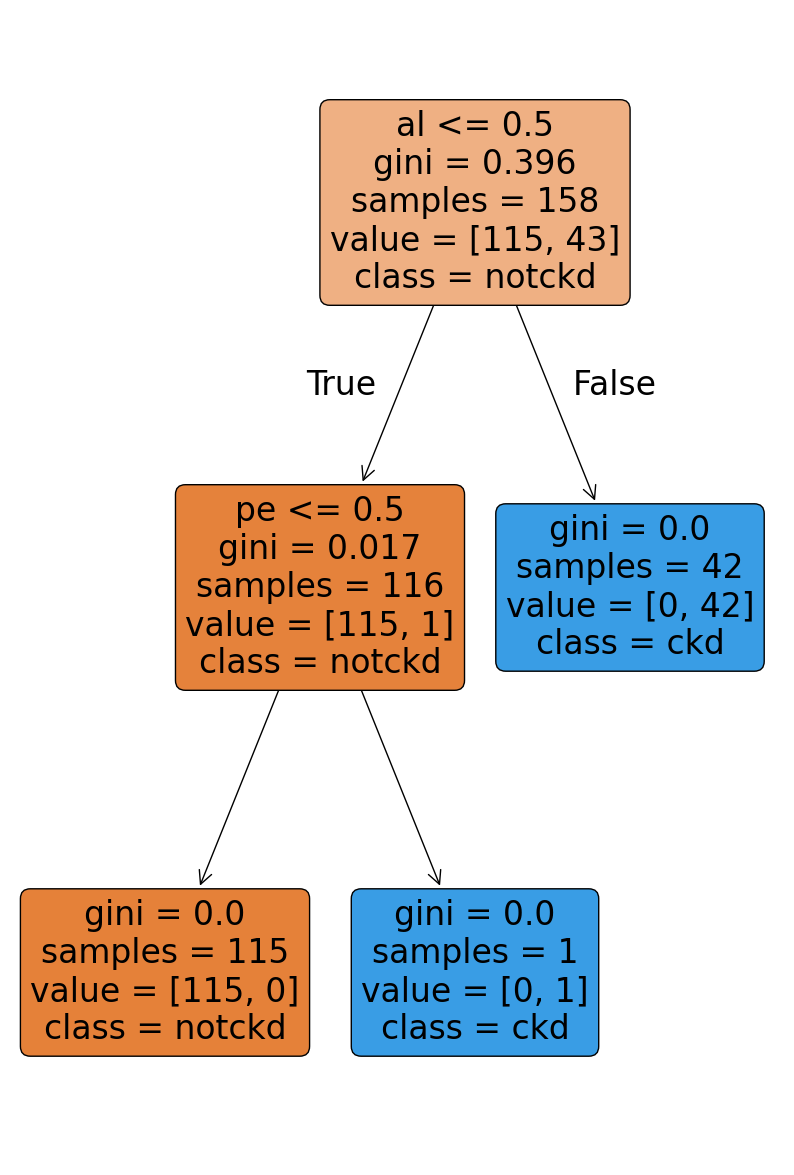

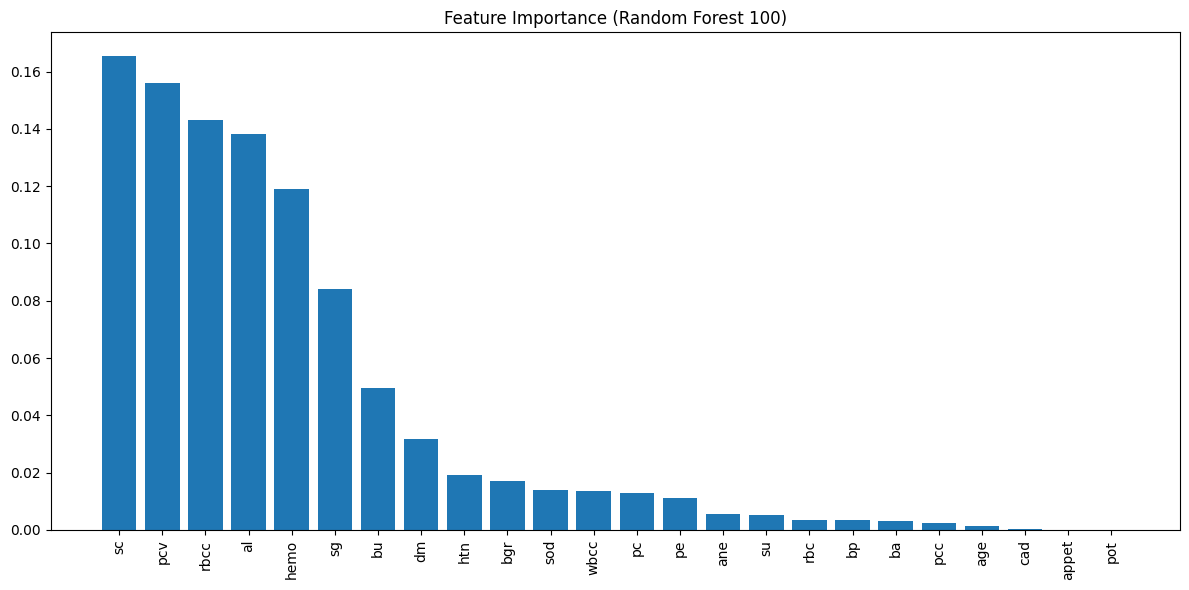

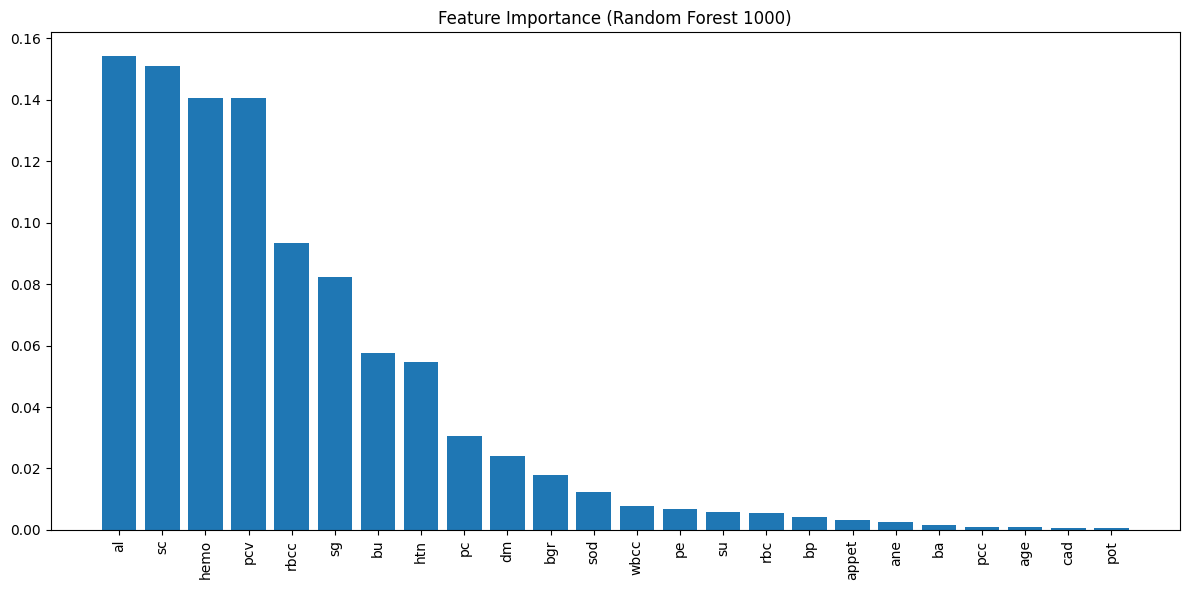

--------------------------------------- 
--------------------------------------- 
🔍​🕵​🌲TREES TRAINED USING 1/2 OF THE MIXED x_filled_med AND EVALUATED ON THE OTHER 1/2

Train: 200, Test: 200)
--------------------------------------- 

RANDOM FOREST WITH ENTROPY & GINI
📈ENTROPY: 
Random Forest Accuracy (su Test set): 1.0
Random Forest Confusion Matrix:
 [[ 80   0]
 [  0 120]]
 
​📉​GINI: 
Random Forest Accuracy (su Test set): 1.0
Random Forest Confusion Matrix:
 [[ 80   0]
 [  0 120]]
--------------------------------------- 

CART WITH ENTROPY & GINI
📈NTROPY: 
CART Tree Accuracy (su Test set): 0.99
CART Tree Confusion Matrix:
 [[ 80   0]
 [  2 118]]
 
​📉​GINI: 
CART Tree Accuracy (su Test set): 0.99
CART Tree Confusion Matrix:
 [[ 80   0]
 [  2 118]]


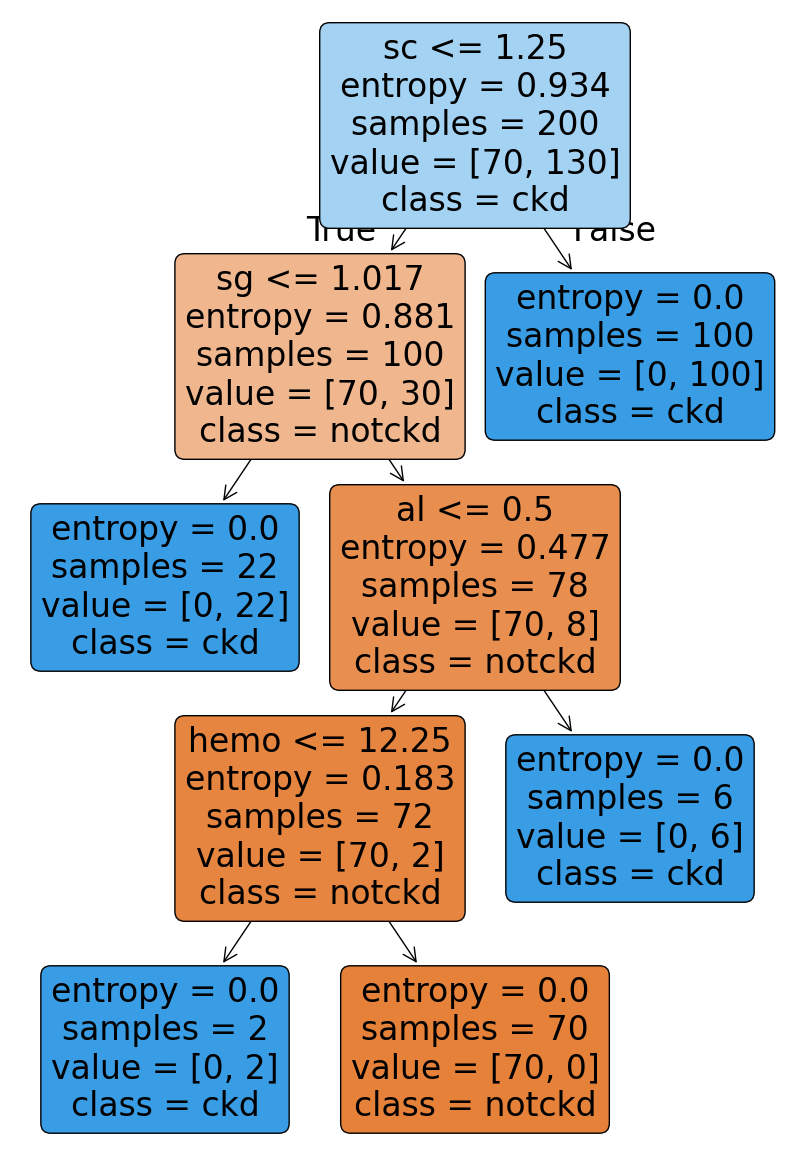

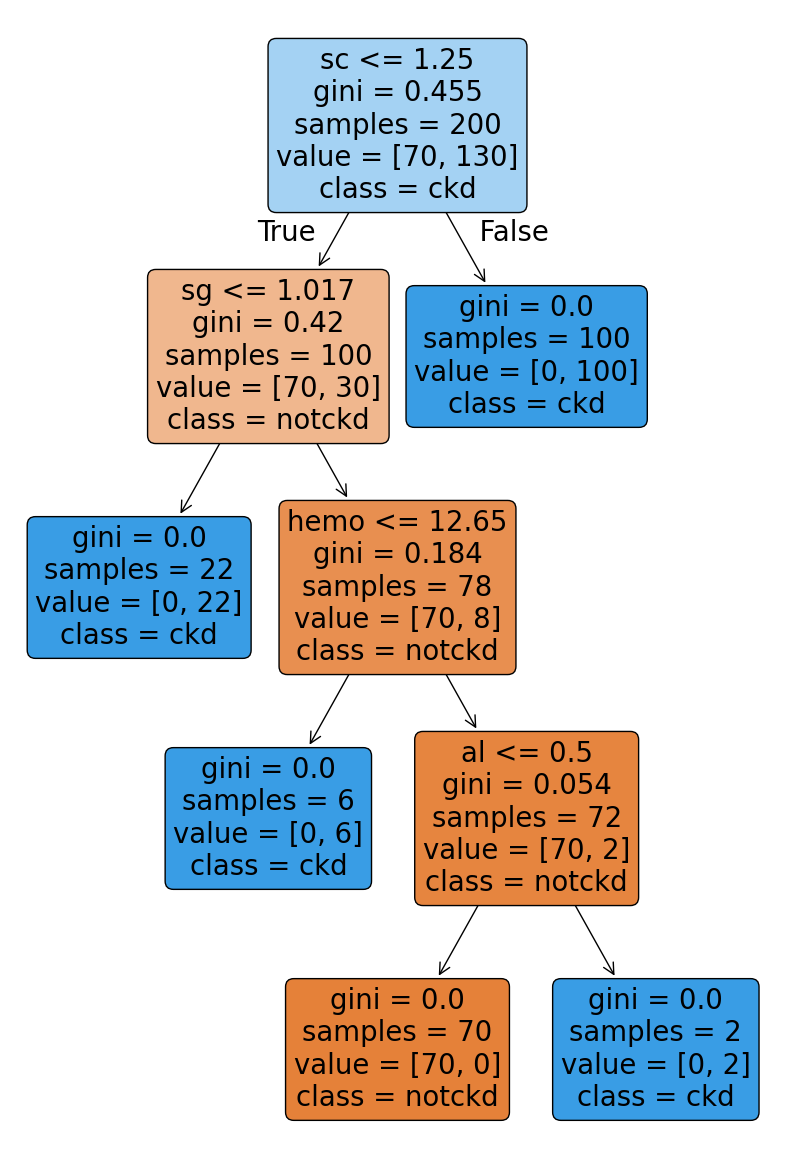

In [4]:
#PART 3: TRAIN THE DECISION TREE(C4.5-CART AND RANDOM FOREST) OVER BOTH THE SETS

print("---------------------------------------")
print("---------------------------------------")
print('🌲​🌲​DECISION TREES TRAINED OVER THE TRAIN SET(ROWS WITHOUT MISSING):')
#%% C4.5

print("📈C4.5(ENTROPY) OVER X :") # Deve essere (400, 25)


# Let us use only the complete data (no missing values) to train the decision tree
target = Xtrain.classk
inform = Xtrain.drop('classk', axis=1)
clfXtrain = tree.DecisionTreeClassifier(criterion='entropy')
clfXtrain = clfXtrain.fit(inform,target)
# now we use x_filled_reg for the prediction
test_pred = clfXtrain.predict(x_filled_reg.drop('classk', axis=1))
plt.figure(figsize=(10,15))
tree.plot_tree(clfXtrain,feature_names=feat_names[:24],
               class_names=target_names,rounded=True,
               proportion =False ,filled = True )
#plt.savefig('fig_training.png' )

print('Performance of the decision tree based on the training dataset only:')
print('accuracy =', accuracy_score(x_filled_reg.classk,test_pred))
print(confusion_matrix(x_filled_reg.classk,test_pred))



# %%CART
print("​📉CART(GINI) OVER x :")    # Deve essere (400, 25)

# Let us use only the complete data (no missing values) to train the decision tree
target = Xtrain.classk
inform = Xtrain.drop('classk', axis=1)
clfXtrain = tree.DecisionTreeClassifier(criterion='gini')
clfXtrain = clfXtrain.fit(inform,target)
# now we use x_filled_reg for the prediction
test_pred = clfXtrain.predict(x_filled_reg.drop('classk', axis=1))
plt.figure(figsize=(10,15))
tree.plot_tree(clfXtrain,feature_names=feat_names[:24],
               class_names=target_names,rounded=True,
               proportion =False ,filled = True )
#plt.savefig('fig_training.png' )

print('Performance of the decision tree based on the training dataset only:')
print('accuracy =', accuracy_score(x_filled_reg.classk,test_pred))
print(confusion_matrix(x_filled_reg.classk,test_pred))



# %% --- TASK 5: Random Forest & Feature Importance ---

print("---------------------------------------")
print("---------------------------------------")
print('🪾🪾RANDOM FOREST TRAINED USING THE FULL SETS x_filled_reg and x_filled_med:')

# Prepariamo i dati di training (Xtrain è pulito)
y_train_label = Xtrain['classk']
X_train_feat = Xtrain.drop('classk', axis=1)

# Prepariamo i dati di test (i due dataset imputati)
# Dataset imputato con Regressione
x_filled_reg_feat = x_filled_reg.drop('classk', axis=1)
x_filled_reg_label = x_filled_reg['classk']
# Dataset imputato con Mediana
x_filled_med_feat = x_filled_med.drop('classk', axis=1)
x_filled_med_label = x_filled_med['classk']

# Definiamo i classificatori (100 e 1000 alberi)
rf_100 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_1000 = RandomForestClassifier(n_estimators=1000, random_state=42)

# --- Addestramento e Test (usiamo RF 100 come esempio principale) ---
rf_100.fit(X_train_feat, y_train_label)
rf_1000.fit(X_train_feat, y_train_label)


# Predizione su x_filled_reg (Regression Imputation)
pred_x_filled_reg100 = rf_100.predict(x_filled_reg_feat)
acc_x100 = accuracy_score(x_filled_reg_label, pred_x_filled_reg100)
cm_x100 = confusion_matrix(x_filled_reg_label, pred_x_filled_reg100)

# Predizione su x_filled_med (Median Imputation)
pred_x_filled_med100 = rf_100.predict(x_filled_med_feat)
acc_y100 = accuracy_score(x_filled_med_label, pred_x_filled_med100)
cm_y100 = confusion_matrix(x_filled_med_label, pred_x_filled_med100)


# Predizione su x_filled_reg (Regression Imputation)
pred_x_filled_reg1000 = rf_1000.predict(x_filled_reg_feat)
acc_x1000 = accuracy_score(x_filled_reg_label, pred_x_filled_reg1000)
cm_x1000 = confusion_matrix(x_filled_reg_label, pred_x_filled_reg1000)

# Predizione su x_filled_med (Median Imputation)
pred_x_filled_med1000 = rf_1000.predict(x_filled_med_feat)
acc_y1000 = accuracy_score(x_filled_med_label, pred_x_filled_med1000)
cm_y1000 = confusion_matrix(x_filled_med_label, pred_x_filled_med1000)


print("\n--- Random Forest (100 trees) Results ---")
print(f"Accuracy su x_filled_reg (Regression): {acc_x100:.4f}")
print(f"Confusion Matrix x_filled_reg:\n{cm_x100}")
print(" ")
print(f"Accuracy su x_filled_med (Median): {acc_y100:.4f}")
print(f"Confusion Matrix x_filled_med:\n{cm_y100}")


print("--------------------------------------- ")


print("\n--- Random Forest (1000 trees) Results ---")
print(f"Accuracy su x_filled_reg (Regression): {acc_x1000:.4f}")
print(f"Confusion Matrix x_filled_reg:\n{cm_x1000}")
print(" ")
print(f"Accuracy su x_filled_med (Median): {acc_y1000:.4f}")
print(f"Confusion Matrix x_filled_med:\n{cm_y1000}")

# --- Feature Importance (Plot) ---
importances = rf_100.feature_importances_
indices = np.argsort(importances)[::-1] # Ordina indici dal più importante al meno
names = [feat_names[i] for i in indices] # Riordina i nomi

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest 100)")
plt.bar(range(X_train_feat.shape[1]), importances[indices])
plt.xticks(range(X_train_feat.shape[1]), names, rotation=90)
plt.tight_layout()
plt.show()


# --- Feature Importance (Plot) ---
importances = rf_1000.feature_importances_
indices = np.argsort(importances)[::-1] # Ordina indici dal più importante al meno
names = [feat_names[i] for i in indices] # Riordina i nomi

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest 1000)")
plt.bar(range(X_train_feat.shape[1]), importances[indices])
plt.xticks(range(X_train_feat.shape[1]), names, rotation=90)
plt.tight_layout()
plt.show()




# %% --- TASK 6: Split, Shuffle & Retrain on x_filled_med ---
print("--------------------------------------- ")
print("--------------------------------------- ")
print('🔍​🕵​🌲TREES TRAINED USING 1/2 OF THE MIXED x_filled_med AND EVALUATED ON THE OTHER 1/2')

# GOAL: Verify the stability and generalization capability of the models (Random Forest vs CART/C4.5).
# Unlike previous steps, here we DO NOT use a fixed 'random_state' (seed).
# This ensures that every time the script runs, a different random subset of patients
# is selected for training and testing, simulating a real-world scenario.
#
# Steps:
# 1. Shuffle the median-imputed dataset (x_filled_med) and split it 50/50 into Train/Test.
# 2. Train a Random Forest (100 trees) and a single Decision Tree (CART) on the Training set.
# 3. Evaluate performance (Accuracy & Confusion Matrix) strictly on the Test set.
#
# If the accuracy remains high and stable across multiple runs, the model is robust
# and not overfitting to a specific permutation of the data.

X_feat_med = x_filled_med.drop('classk', axis=1)    #data without the label
y_label_med = x_filled_med['classk']                #ground truth(label)

# Split 50% Training, 50% Test
X_tr, X_ts, y_tr, y_ts = train_test_split(X_feat_med, y_label_med, test_size=0.5, shuffle=True)

print(f"\nTrain: {X_tr.shape[0]}, Test: {X_ts.shape[0]})")

print("--------------------------------------- ")

print("\nRANDOM FOREST WITH ENTROPY & GINI") # Deve essere (400, 25)

# --- 6.1 Random Forest Classifier ---
rf_curr = RandomForestClassifier(n_estimators=100, criterion="entropy") # Nessun seed fisso
rf_curr.fit(X_tr, y_tr)
pred_rf = rf_curr.predict(X_ts)

print("📈ENTROPY: ")

print("Random Forest Accuracy (su Test set):", accuracy_score(y_ts, pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_ts, pred_rf))

print(" ")

# --- 6.1 Random Forest Classifier ---
rf_curr = RandomForestClassifier(n_estimators=100, criterion="gini") # Nessun seed fisso
rf_curr.fit(X_tr, y_tr)
pred_rf = rf_curr.predict(X_ts)
print("​📉​GINI: ")

print("Random Forest Accuracy (su Test set):", accuracy_score(y_ts, pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_ts, pred_rf))



print("--------------------------------------- ")

print("\nCART WITH ENTROPY & GINI") # Deve essere (400, 25)


#####################################################
#ENTROPY
# --- 6.2 CART (Decision Tree) Classifier ---
# Usiamo gli stessi parametri del primo albero nel tuo codice originale (entropy)
cart_curr = tree.DecisionTreeClassifier(criterion='entropy') # Nessun seed fisso
cart_curr.fit(X_tr, y_tr)
pred_cart = cart_curr.predict(X_ts)

plt.figure(figsize=(10,15))
tree.plot_tree(cart_curr,feature_names=feat_names[:24],
               class_names=target_names,rounded=True,
               proportion =False ,filled = True )
print("📈NTROPY: ")

print("CART Tree Accuracy (su Test set):", accuracy_score(y_ts, pred_cart))
print("CART Tree Confusion Matrix:\n", confusion_matrix(y_ts, pred_cart))

print(" ")
#GINI
# --- 6.2 CART (Decision Tree) Classifier ---
# Usiamo gli stessi parametri del primo albero nel tuo codice originale (entropy)
cart_curr = tree.DecisionTreeClassifier(criterion='gini') # Nessun seed fisso
cart_curr.fit(X_tr, y_tr)
pred_cart = cart_curr.predict(X_ts)

plt.figure(figsize=(10,15))
tree.plot_tree(cart_curr,feature_names=feat_names[:24],
               class_names=target_names,rounded=True,
               proportion =False ,filled = True )

print("​📉​GINI: ")

print("CART Tree Accuracy (su Test set):", accuracy_score(y_ts, pred_cart))
print("CART Tree Confusion Matrix:\n", confusion_matrix(y_ts, pred_cart))














In [ ]:
"""
1 age age numerical
2 bp blood pressure (mm/Hg) numerical
3 sg specific gravity categorical           IMPORTANT
4 al albumin categorical                   IMPORTANT
5 su sugar categorical
6 rbc red blood cells categorical
7 pc pus cell categorical
8 pcc ps cell clumps categorical
9 ba bacteria categorical
10 bgr blood glucose random (mg/dl) numerical
11 bu blood urea (mg/dl) numerical
12 sc serum creatinine (mg/dl) numerical    IMPORTANT
13 sod sodium (mEq/L) numerical
14 pot potassium (mEq/L) numerical
15 hemo hemoglobin (gms) numerical          IMPORTANT
16 pcv packet cell volume numerical
17 wbcc white blood cell count numerical        IMPORTANT
18 rbcc red blood cell count (million/cmm) numerical
19 htn hypertension categorical
20 dm diabetes mellitus categorical
21 cad coronary artery disease categorical
22 appet appetite categorical
23 pe pedal edema categorical           IMPORTANT
24 ane anemia categorical
"""
